In [26]:
from src.models import load_model_from_checkpoint, ClassificationNet


model = load_model_from_checkpoint('../models/vgg_128x128.ckpt', ClassificationNet)

c:\Users\tyoma\miniforge-pypy3\envs\course-work\Lib\site-packages\src\models\utils.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(str(checkpoint

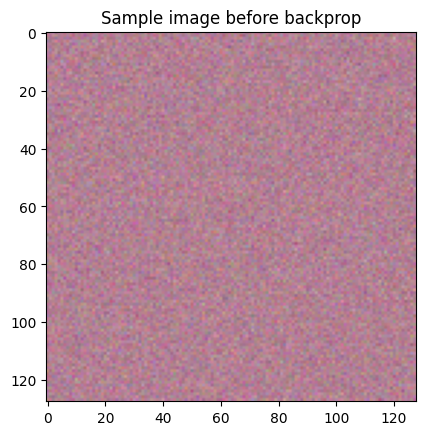

In [27]:
import matplotlib.pyplot as plt
import torch

from torch.optim import SGD

sample_images = 0.05 * torch.randn(15, 3, 128, 128)#.clip(0, 1)
sample_images = sample_images + torch.tensor([179 / 255, 128 / 255, 147 / 255]).reshape(1, 3, 1, 1)
sample_images = sample_images.clip(0, 1)
sample_images.requires_grad = True
start = sample_images.clone().detach()
plt.imshow(sample_images.detach()[0].permute(1, 2, 0))
plt.title('Sample image before backprop')
plt.show()

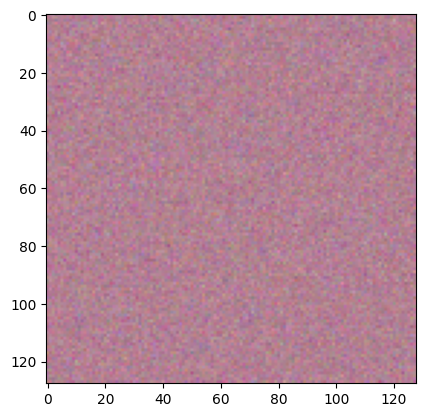

0.45603400468826294:  11%|█         | 5341/50000 [2:08:20<23:08:52,  1.87s/it]

In [23]:
from IPython.display import clear_output

from torch import nn
from torch.optim.lr_scheduler import StepLR
from torchmetrics.image import TotalVariation

from tqdm.auto import tqdm

losses = []
crit = nn.BCEWithLogitsLoss()
target = torch.ones((sample_images.shape[0],), dtype=torch.float32)

tv = TotalVariation(reduction='mean')

optim = SGD([sample_images], lr=0.1)
scheduler = StepLR(optim, 10_000, gamma=0.1)

bar = tqdm(range(50_000))
for i in bar:
    optim.zero_grad()
    model.zero_grad()
    preds = model(sample_images)[:, 1]
    bce_loss = crit(preds, target)
    loss = bce_loss + 1e-4 * tv(sample_images)
    loss.backward()
    optim.step()
    model.zero_grad()
    bar.set_description(str(loss.item()))
    scheduler.step(i)
    losses.append(float(loss.item()))
    with torch.no_grad():
        sample_images.clip_(0, 1)

    if i % 100 == 0:
        clear_output(True)
        plt.imshow(sample_images.detach()[0].permute(1, 2, 0))
        plt.show()

In [25]:
import torch.nn.functional as F

F.sigmoid(model(sample_images)[..., 1])

tensor([0.9816, 0.9793, 0.9796, 0.9809, 0.9814, 0.9796, 0.9799, 0.9790, 0.9802,
        0.9803, 0.9807, 0.9849, 0.9804, 0.9817, 0.9797],
       grad_fn=<SigmoidBackward0>)

tensor(0.0311)


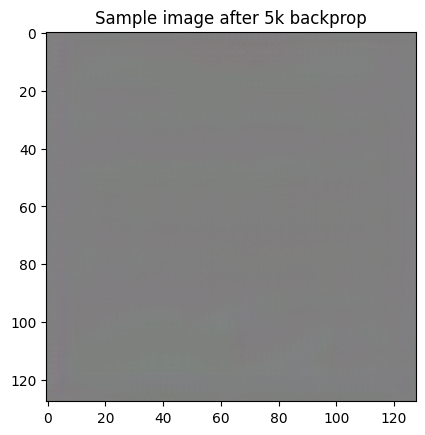

In [9]:
print(torch.abs(start - sample_images.detach()).max())
plt.imshow(sample_images.detach()[0].permute(1, 2, 0))
plt.title('Sample image after 5k backprop')
plt.show()

In [32]:
import cv2

for i in range(15):
    starter = start[i].permute(1, 2, 0)
    sample = sample_images.detach()[i].permute(1, 2, 0)

    cv2.imwrite(f'../results/e1/start_{i}.png', (255 * starter.numpy()[..., ::-1]).astype('uint8'))
    cv2.imwrite(f'../results/e1/sample_{i}.png', (255 * sample.numpy()[..., ::-1]).astype('uint8'))